## PUBG Finish Placement Prediction

- **배틀그라운드 *PlayerUnknown's BattleGrounds* 플레이어의 등수**를 예측
- 훈련 데이터 4.45백만, 테스트 데이터 1.93백만
- 제출 : 플레이어 ID 당 등수를 퍼센트로(1: 1등 ~ 0: 최대 100인 마지막 등수)
- 평가 : MAE (Mean Absolute Error)

### Data Description (총 29)

- winPlacePerc : 타깃
- Id: 플레이어 ID
- groupId: 팀 ID
- matchId : 매치 아이디
- matchType : 매치 종류 - 솔로, 듀오, 스쿼드, 솔로-fpp, 듀오-fpp, 스쿼드-fpp(그외는 이벤트나 커스텀 매치)
- matchDuration : 매치 총 시간
- numGroups : 해당 매치 팀 수
- boosts : 부스트 (아이템 사용)
- heals : 회복 (아이템 사용)
- damageDealt : 피해량 (스스로 초래한 경우는 제외)
- assists : 어시 (팀원이 킬한 적에게 데미지를 입힘)
- DBNOs : 기절
- kills : 킬
- headshotKills : 헤드샷 킬
- killStreaks: 최다 연속 킬
- longestKill: 최장거리 킬
- roadKills: 로드킬(차량 등을 타고 킬)
- teamKills : 팀킬
- revives: 팀원 부활
- rideDistance: 차량 이동 거리 (미터)
- swimDistance: 수영 이동 거리 (미터)
- walkDistance : 도보 이동 거리 (미터)
- vehicleDestroy: 파괴한 차량
- weaponsAcquired : 무기 획득
- rankPoints: elo-like ranking *inconsistent, API next version 시  ㅇ덱ㄷㅊㅁㅅㄷㅇ
- winPoints: 승리 레이팅
- killPoints: 킬 레이팅
- killPlace : 킬 등수 (매치 내)
- numGroups: 해당 매치에 가지고 있는 그룹 수
- maxPlace: 매치 내 가능한 최대 등수 = 꼴등

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import warnings
%matplotlib inline
warnings.filterwarnings("ignore")

In [0]:
# Memory saving function credit to https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

In [9]:
train = pd.read_csv('train_V2.csv')
train = reduce_mem_usage(train)

Memory usage of dataframe is 983.90 MB
Memory usage after optimization is: 288.39 MB
Decreased by 70.7%


In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4446966 entries, 0 to 4446965
Data columns (total 29 columns):
Id                 object
groupId            object
matchId            object
assists            int8
boosts             int8
damageDealt        float16
DBNOs              int8
headshotKills      int8
heals              int8
killPlace          int8
killPoints         int16
kills              int8
killStreaks        int8
longestKill        float16
matchDuration      int16
matchType          object
maxPlace           int8
numGroups          int8
rankPoints         int16
revives            int8
rideDistance       float16
roadKills          int8
swimDistance       float16
teamKills          int8
vehicleDestroys    int8
walkDistance       float16
weaponsAcquired    int16
winPoints          int16
winPlacePerc       float16
dtypes: float16(6), int16(5), int8(14), object(4)
memory usage: 288.4+ MB


In [86]:
sum(np.isnan(train['winPlacePerc']))

1

In [0]:
train = train[np.isfinite(train['winPlacePerc'])]

타깃 변수 중 NaN 값 (1개) drop

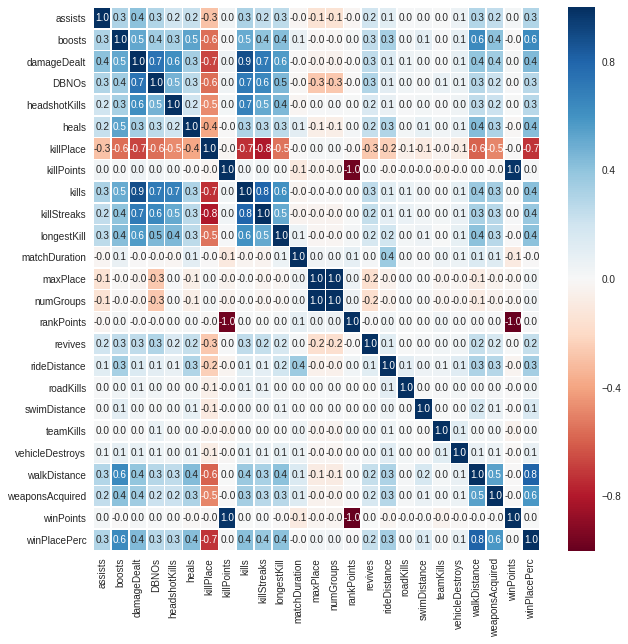

In [32]:
f,ax = plt.subplots(figsize=(10, 10))
sns.heatmap(train.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax, cmap="RdBu")
plt.show()

타깃과 가장 상관이 높은 변수들
* boost
* killPlace
* walkDistance
* weaponsAcquired
* 그외: damageDealt, kills, killStreaks, longestkill

### Kills

In [11]:
train['kills'].quantile(0.99)

7.0

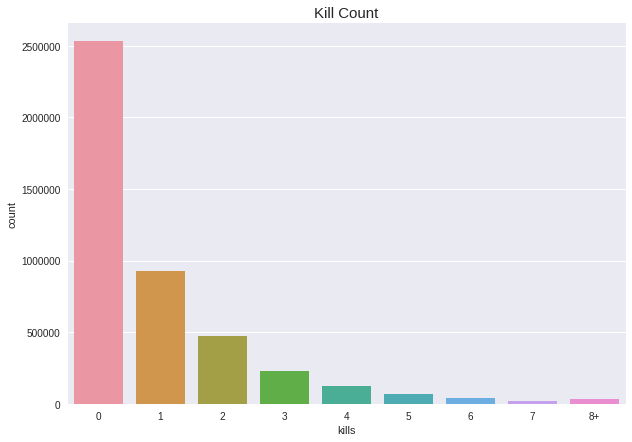

In [12]:
data = train.copy()
data.loc[data['kills'] > data['kills'].quantile(0.99)] = '8+'
plt.figure(figsize=(10,7))
sns.countplot(data['kills'].astype('str').sort_values())
plt.title("Kill Count",fontsize=15)
plt.show()


In [13]:
len(data[data['kills']==0])/len(data)

0.5688647046098396

<Figure size 720x504 with 0 Axes>

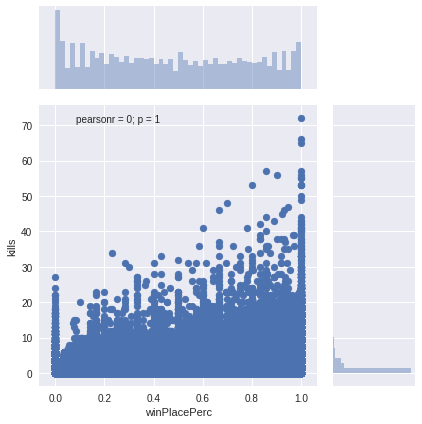

In [14]:
plt.figure(figsize=(10,7))
sns.jointplot(x="winPlacePerc", y="kills", data=train, ratio=3)
plt.show()

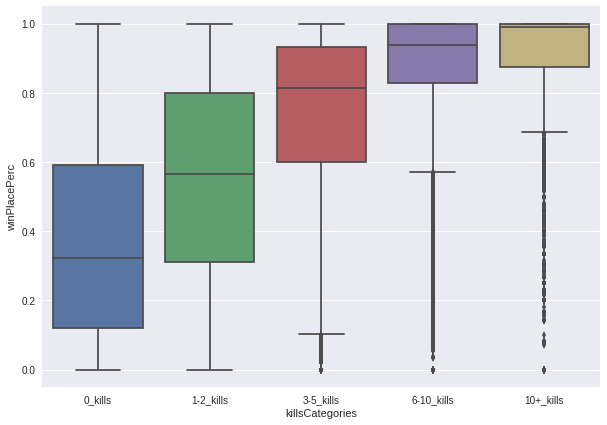

In [18]:
kills = train.copy()

kills['killsCategories'] = pd.cut(kills['kills'], [-1, 0, 2, 5, 10, kills['kills'].max()], labels=['0_kills','1-2_kills', '3-5_kills', '6-10_kills', '10+_kills'])

plt.figure(figsize=(10,7))
sns.boxplot(x="killsCategories", y="winPlacePerc", data=kills)
plt.show()

### walkDistance

In [21]:
len(train[train['walkDistance']==0])/len(train)

0.022397967513131424

In [19]:
train['walkDistance'].quantile(0.99)

4396.0

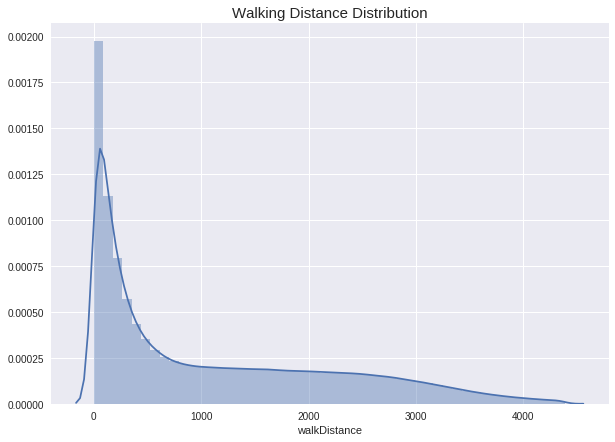

In [20]:
data = train.copy()
data = data[data['walkDistance'] < train['walkDistance'].quantile(0.99)]
plt.figure(figsize=(10,7))
plt.title("Walking Distance Distribution",fontsize=15)
sns.distplot(data['walkDistance'])
plt.show()

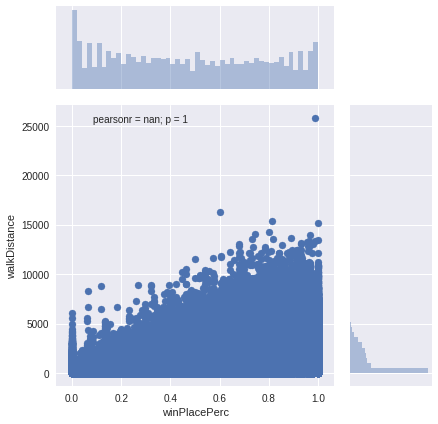

In [22]:
sns.jointplot(x="winPlacePerc", y="walkDistance",  data=train, ratio=3)
plt.show()

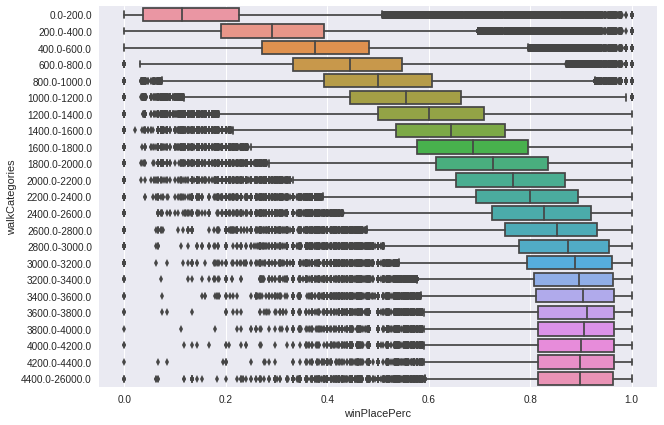

In [36]:
walk = train[['walkDistance', 'winPlacePerc']].copy()

cut_range = np.linspace(0,4400,23)
cut_range = np.append(cut_range, 26000)
walk['walkCategories'] = pd.cut(walk['walkDistance'], cut_range, labels=["{}-{}".format(a_, b_) for a_, b_ in zip(cut_range[:23], cut_range[1:])], include_lowest=True)
plt.figure(figsize=(10,7))
sns.boxplot(x="winPlacePerc", y="walkCategories", data=walk)
plt.show()

### rideDistance

In [23]:
len(train[train['rideDistance']==0])/len(train)

0.744199303525145

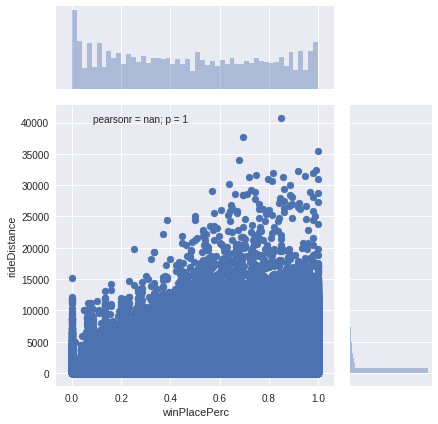

In [24]:
sns.jointplot(x="winPlacePerc", y="rideDistance", data=train, ratio=3)
plt.show()

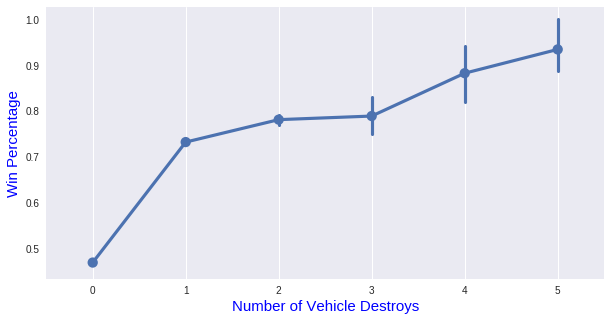

In [25]:
f,ax1 = plt.subplots(figsize =(10,5))
sns.pointplot(x='vehicleDestroys',y='winPlacePerc',data=train,alpha=0.8)
plt.xlabel('Number of Vehicle Destroys',fontsize = 15,color='blue')
plt.ylabel('Win Percentage',fontsize = 15,color='blue')
plt.grid()
plt.show()

### Heals & Boosts

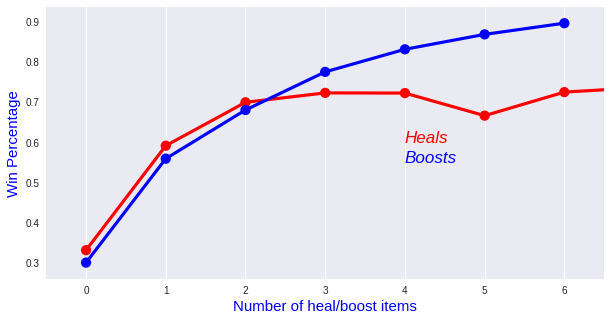

In [29]:
data = train.copy()
data = data[data['heals'] < data['heals'].quantile(0.99)]
data = data[data['boosts'] < data['boosts'].quantile(0.99)]

f,ax1 = plt.subplots(figsize =(10,5))
sns.pointplot(x='heals',y='winPlacePerc',data=data,color='red',alpha=0.8)
sns.pointplot(x='boosts',y='winPlacePerc',data=data,color='blue',alpha=0.8)
plt.text(4,0.6,'Heals',color='red',fontsize = 17,style = 'italic')
plt.text(4,0.55,'Boosts',color='blue',fontsize = 17,style = 'italic')
plt.xlabel('Number of heal/boost items',fontsize = 15,color='blue')
plt.ylabel('Win Percentage',fontsize = 15,color='blue')
plt.grid()
plt.show()

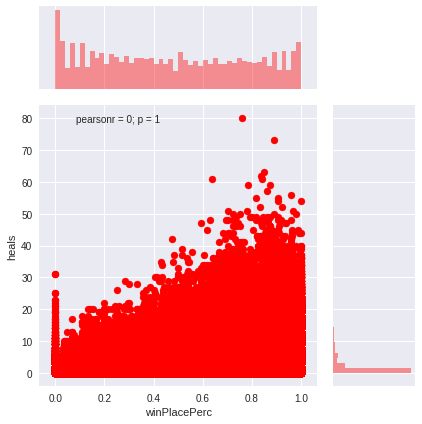

In [27]:
sns.jointplot(x="winPlacePerc", y="heals", data=train, ratio=3, color="red")
plt.show()

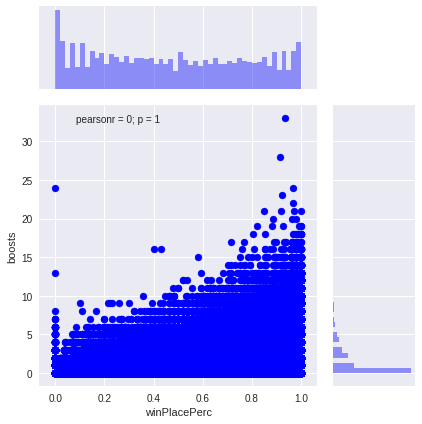

In [28]:
sns.jointplot(x="winPlacePerc", y="boosts", data=train, ratio=3, color="blue")
plt.show()

### weaponsAcquired

In [74]:
weapon = train[['weaponsAcquired','winPlacePerc']].copy()
weapon['weaponsAcquired'].quantile(0.99)

10.0

In [0]:
weapon.loc[weapon['weaponsAcquired'] > 8,'weaponsAcquired'] = '9+'

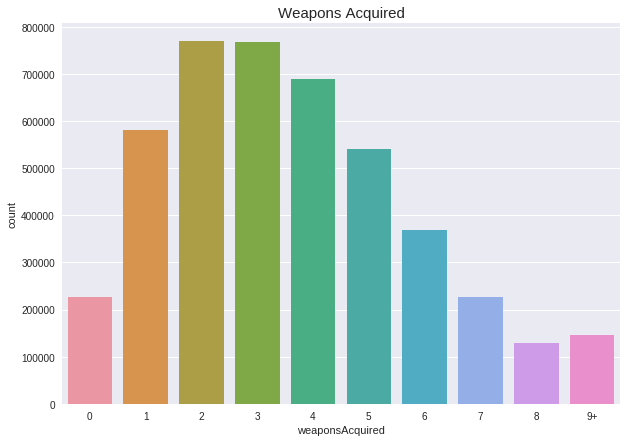

In [44]:
plt.figure(figsize=(10,7))
sns.countplot(weapon['weaponsAcquired'].astype('str').sort_values())
plt.title("Weapons Acquired",fontsize=15)
plt.show()

In [0]:
a=weapon.groupby('weaponsAcquired').mean().reset_index()['weaponsAcquired']

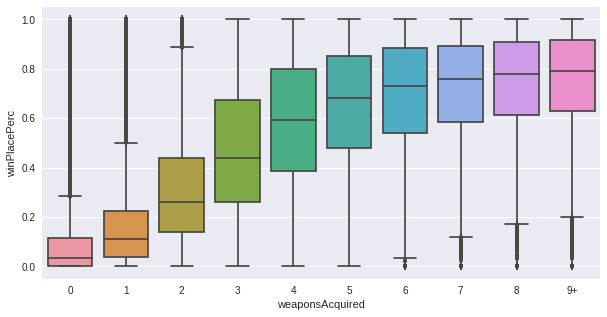

In [81]:
plt.figure(figsize=(10,5))
sns.boxplot(x='weaponsAcquired', y='winPlacePerc', data=weapon,order=a)
plt.show()

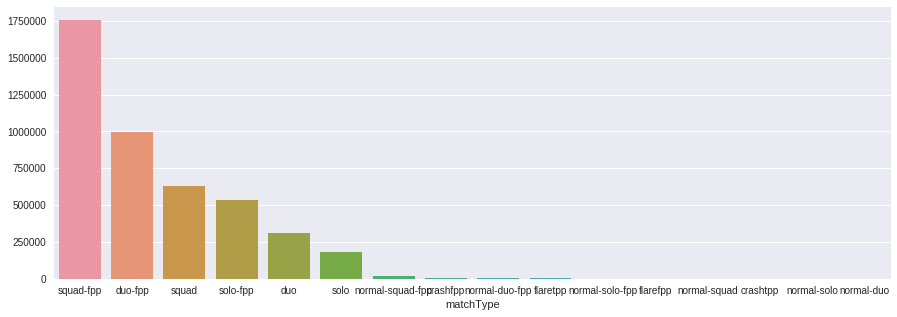

In [93]:
plt.figure(figsize=(15,5))
types = train.groupby('matchType').size().sort_values(ascending=False)
sns.barplot(x=types.index,y=types.values);
plt.show()

### Target Variable

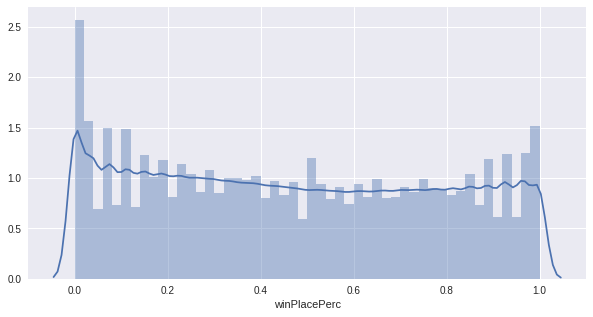

In [91]:
plt.figure(figsize=(10,5))
sns.distplot(train['winPlacePerc'])
plt.show()